In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
dataset_path = 'C:/Users/koush/Downloads/archive (4)/UTKFace'

In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from  tensorflow.keras.preprocessing.image import load_img 
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [5]:
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(dataset_path)):
    image_path = os.path.join(dataset_path, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [6]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,C:/Users/koush/Downloads/archive (4)/UTKFace\1...,100,0
1,C:/Users/koush/Downloads/archive (4)/UTKFace\1...,100,0
2,C:/Users/koush/Downloads/archive (4)/UTKFace\1...,100,1
3,C:/Users/koush/Downloads/archive (4)/UTKFace\1...,100,1
4,C:/Users/koush/Downloads/archive (4)/UTKFace\1...,100,1


In [7]:
gender_dict = {0:'Male', 1:'Female'}

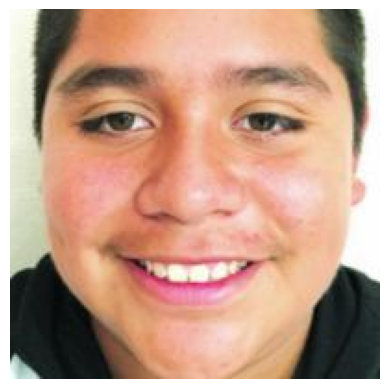

In [8]:
from PIL import Image
img = Image.open(df['image'][700])
plt.axis('off')
plt.imshow(img)

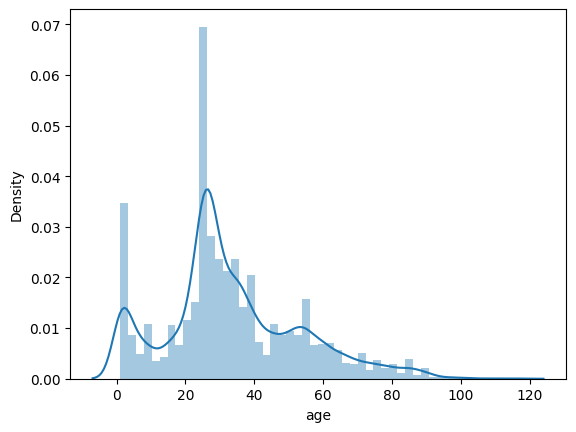

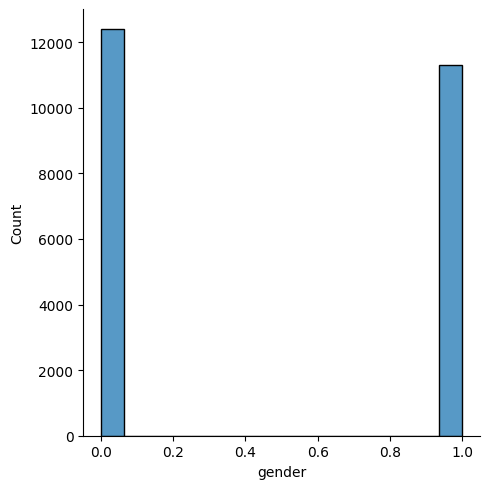

In [9]:
sns.distplot(df['age'])
sns.displot(df["gender"])

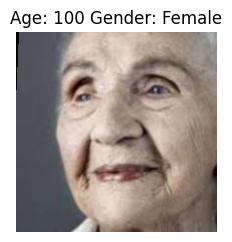

In [10]:

# Get the desired range from the user
start_index = int(input("enter stating index"))
end_index = int(input("enter the last index"))

plt.figure(figsize=(15, 15))
files = df.iloc[start_index:end_index]

# Adjust the subplot grid to accommodate the number of files
num_cols = 5
num_rows = (len(files) + num_cols - 1) // num_cols  # Calculate number of rows needed

for index, file, age, gender in files.itertuples():
    plt.subplot(num_rows, num_cols, index - start_index + 1)  # Adjust index for subplot
    img = load_img(file)  # Assuming 'load_img' is defined elsewhere
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

plt.show()

In [11]:
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from PIL import Image
def extract_features(images):
    features = []
    for image in tqdm(images):
        try:
            img = load_img(image, color_mode='grayscale')
            img = img.resize((128, 128), Image.Resampling.LANCZOS)
            img = np.array(img)
            features.append(img)
        except Exception as e:
            print(f"Error loading image {image}: {e}")
    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features
X = extract_features(df['image'])

100%|██████████| 23708/23708 [04:36<00:00, 85.75it/s] 


In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam

def create_multi_output_model(input_shape=(128, 128, 1), learning_rate=0.001):
    inputs = Input(input_shape)
    x = Conv2D(32, kernel_size=(3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(64, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(256, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)

    # Fully connected layers for gender prediction
    gender = Dense(256)(x)
    gender = BatchNormalization()(gender)
    gender = Activation('relu')(gender)
    gender = Dropout(0.5)(gender)
    gender = Dense(128)(gender)
    gender = BatchNormalization()(gender)
    gender = Activation('relu')(gender)
    gender = Dropout(0.5)(gender)
    gender_output = Dense(1, activation='sigmoid', name='gender_output')(gender)
    age = Dense(256)(x)
    age = BatchNormalization()(age)
    age = Activation('relu')(age)
    age = Dropout(0.5)(age)
    age = Dense(128)(age)
    age = BatchNormalization()(age)
    age = Activation('relu')(age)
    age = Dropout(0.5)(age)
    age_output = Dense(1, activation='linear', name='age_output')(age)
    model = Model(inputs=inputs, outputs=[gender_output, age_output])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss={
            'gender_output': 'binary_crossentropy',
            'age_output': 'mean_absolute_error'
        },
        metrics={
            'gender_output': ['accuracy'],
            'age_output': ['mae']
        }
    )
    return model
input_shape = (128, 128, 1)
model = create_multi_output_model(input_shape)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 256) │          0 │ activation_3[0][

 Total params: 8,848,002 (33.75 MB)

 Trainable params: 8,845,506 (33.74 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [13]:
X.shape

(23708, 128, 128, 1)

In [14]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [15]:
# plot the model
%pip install pydot
%pip install pydot graphviz



Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


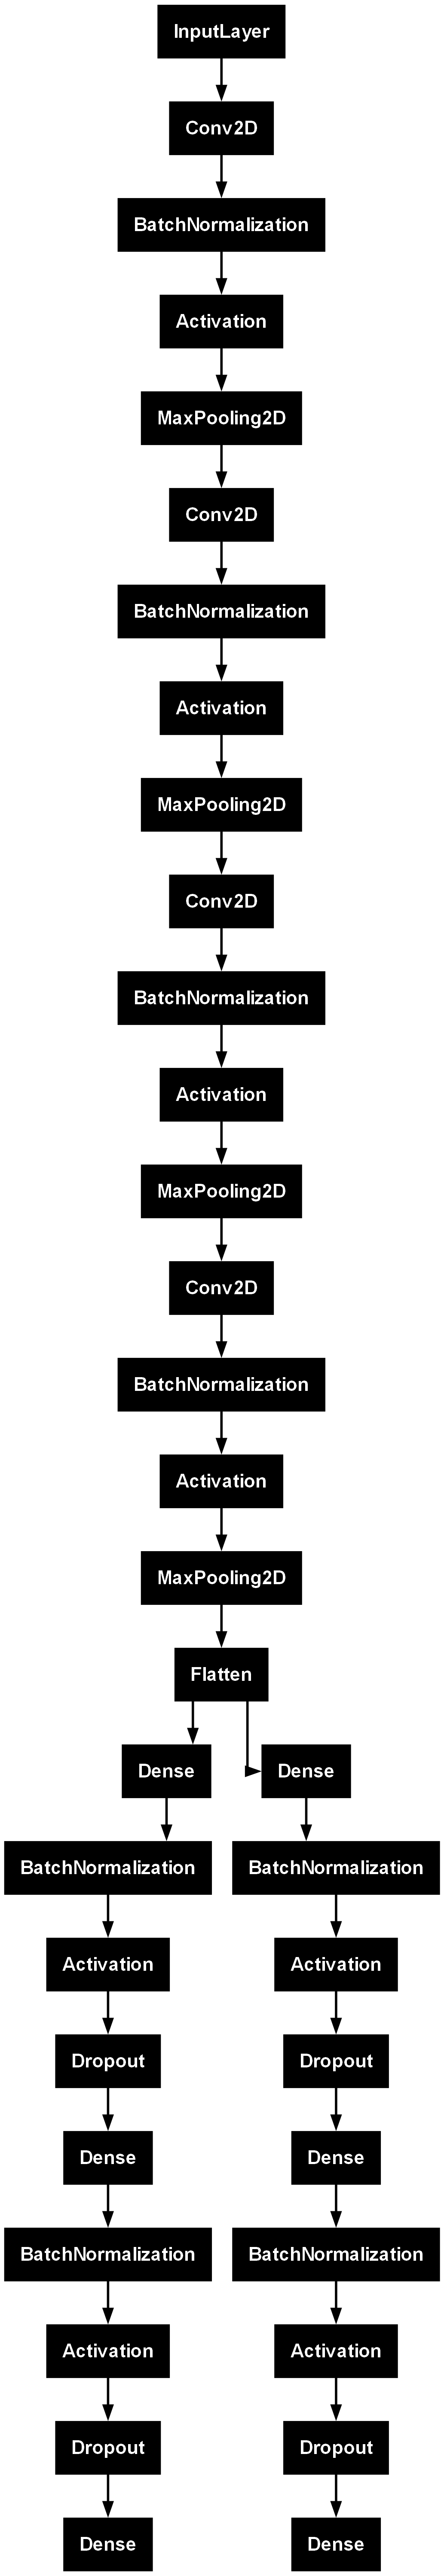

In [16]:
from keras.utils import plot_model
plot_model(model)

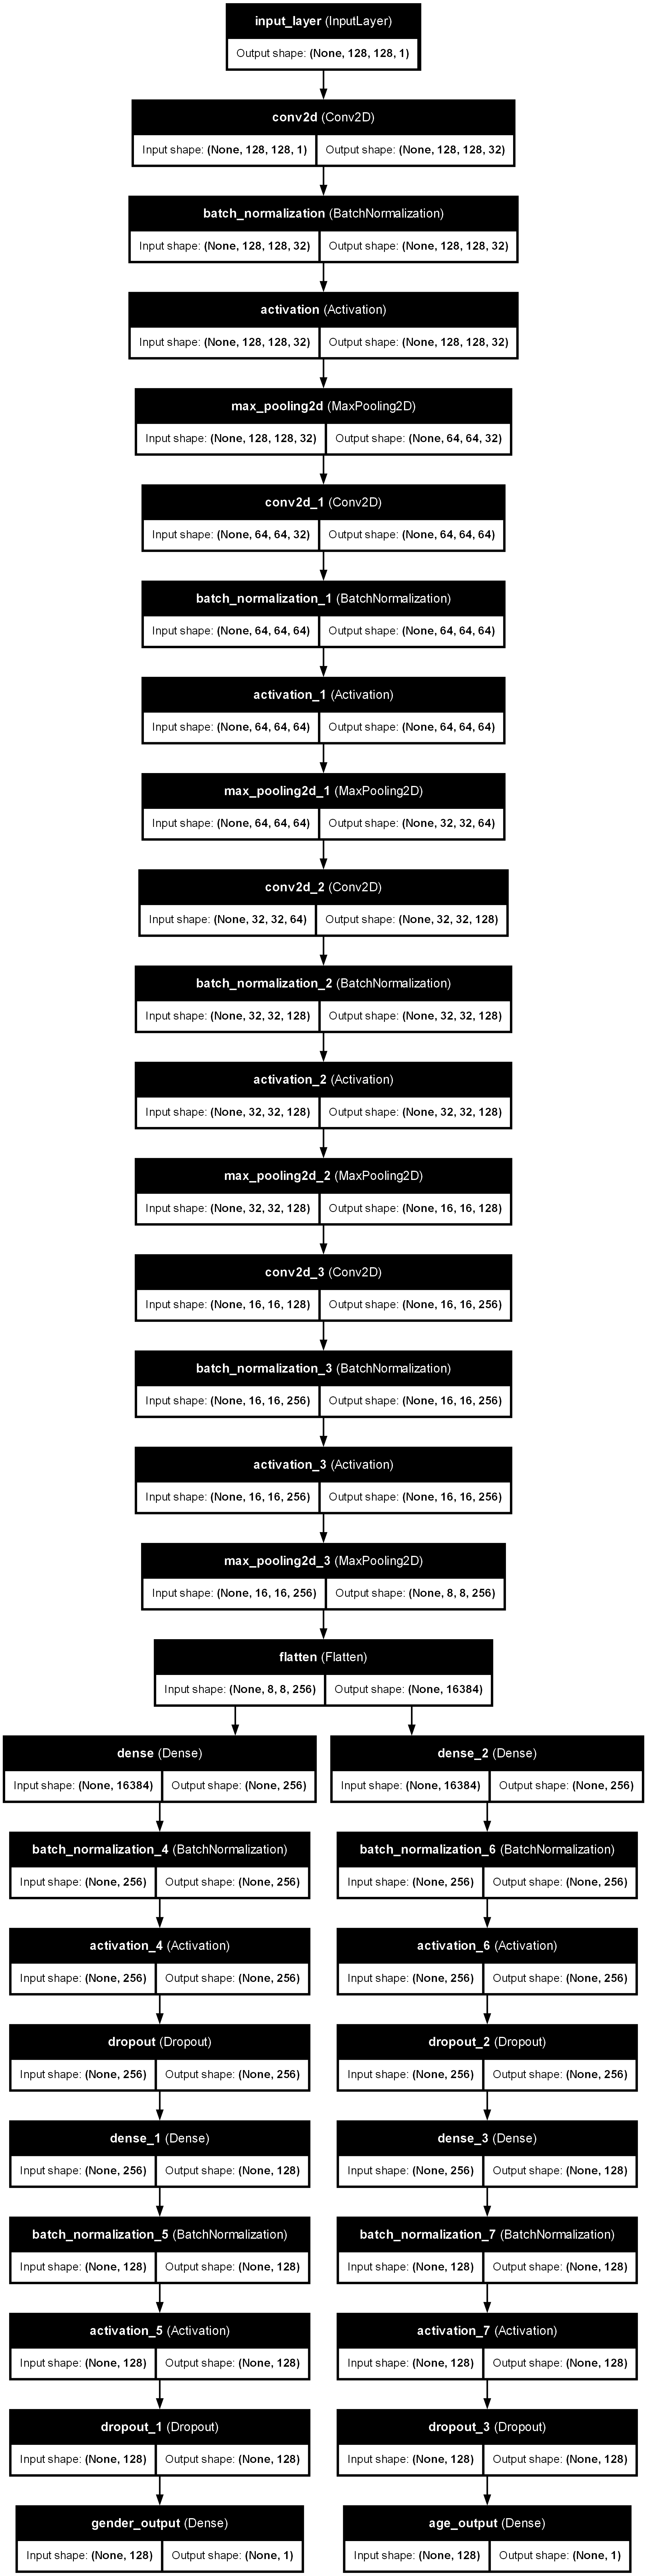

In [17]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [18]:

history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 353s 582ms/step - age_output_mae: 18.5097 - gender_output_accuracy: 0.7480 - loss: 19.0382 - val_age_output_mae: 35.6616 - val_gender_output_accuracy: 0.7347 - val_loss: 36.1876
Epoch 2/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 357s 602ms/step - age_output_mae: 7.2414 - gender_output_accuracy: 0.8638 - loss: 7.5465 - val_age_output_mae: 26.3258 - val_gender_output_accuracy: 0.8011 - val_loss: 26.7499
Epoch 3/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 412s 694ms/step - age_output_mae: 6.6711 - gender_output_accuracy: 0.8928 - loss: 6.9195 - val_age_output_mae: 27.2007 - val_gender_output_accuracy: 0.8212 - val_loss: 27.5952
Epoch 4/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 340s 574ms/step - age_output_mae: 6.2389 - gender_output_accuracy: 0.9006 - loss: 6.4711 - val_age_output_mae: 24.3612 - val_gender_output_accuracy: 0.8311 - val_loss: 24.7731
Epoch 5/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 382s 644ms/step - age_output_mae: 5.9541 - gender_output_accuracy: 0.9069 - loss: 6.1676 - val

Epoch 1/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 350s 590ms/step - age_output_mae: 5.0985 - gender_output_accuracy: 0.9486 - loss: 5.2274 - val_age_output_mae: 17.1186 - val_gender_output_accuracy: 0.8543 - val_loss: 17.5974
Epoch 2/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 347s 585ms/step - age_output_mae: 4.8964 - gender_output_accuracy: 0.9556 - loss: 5.0083 - val_age_output_mae: 18.4253 - val_gender_output_accuracy: 0.8254 - val_loss: 18.8664
Epoch 3/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 323s 545ms/step - age_output_mae: 4.7196 - gender_output_accuracy: 0.9648 - loss: 4.8113 - val_age_output_mae: 14.3702 - val_gender_output_accuracy: 0.8709 - val_loss: 14.7686
Epoch 4/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 301s 507ms/step - age_output_mae: 4.6275 - gender_output_accuracy: 0.9651 - loss: 4.7178 - val_age_output_mae: 16.9403 - val_gender_output_accuracy: 0.8684 - val_loss: 17.3688
Epoch 5/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 300s 505ms/step - age_output_mae: 4.5611 - gender_output_accuracy: 0.9672 - loss: 4.6475 - val_a

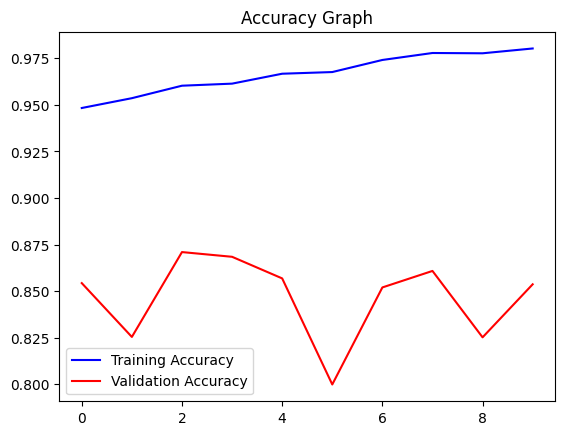

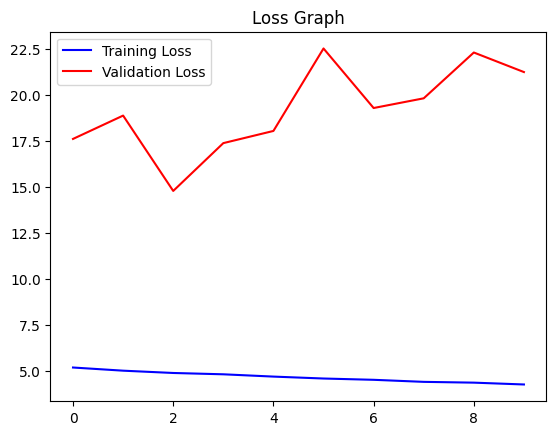

In [19]:
history = model.fit(
    x=X,
    y=[y_gender, y_age],
    batch_size=32,
    epochs=10,
    validation_split=0.2
)
acc = history.history['gender_output_accuracy'] 
val_acc = history.history['val_gender_output_accuracy']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

Original Gender: Female Original Age: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
Predicted Gender: Female Predicted Age: 1


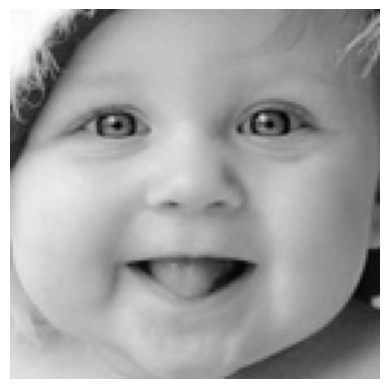

In [20]:
image_index = 2300
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray')

In [24]:
if(pred_age>0 & pred_age<=10):
    print("Food Recommendations:")
    print("fruits, vegetables, whole grains, and proteins.")
    print("Exercise Recommendations:")
    print( "Running, playground activities,Jumping rope, playing basketball")
    print("Books Recommendations:")
    print(" Goodnight Moon by Margaret Wise Brown, The Very Hungry Caterpillar by Eric Carle")
    print("Music Recommendations:")
    print("Twinkle Twinkle Little Star,The Wheels on the Bus,Baby Shark")
elif(pred_age>=11 & pred_age<=20):
    print("Food Recomendations")
    print("Lean meats, beans, nuts,fruits, vegetables, and whole grains")
    print("Exercise Recommendations:")
    print("Running, swimming, cycling,Weight lifting, resistance exercises,soccer, basketball")
    print("Books Recommendations:")
    print("Harry Potter series by J.K. Rowling, The Hunger Games by Suzanne Collins.")
    print("Music Recommendations:")
    print("The Beatles, Queen,Imagine Dragons")
elif(pred_age>=21 & pred_age<=30):
    print("Food Recommendations: ")
    print("Lean meats, eggs, legumes,Avocados, nuts, olive oil,Include a variety of foods from all food groups")
    print("Exercise Recommendations: ")
    print("Stretching exercises, yoga,swimming, cycling, Lifting weights")
    print("Books Recommendations: ")
    print("The Night Circus by Erin Morgenstern, Normal People by Sally Rooney")
    print("Music Recommendations: ")
    print("Taylor Swift, Ed Sheeran, Hozier")
elif(pred_age>=31 & pred_age<=40):
    print("Food Recommendations: ")
    print("Lean meats, eggs, legumes, Avocados, nuts, olive oil,Include a variety of foods from all food groups")
    print("Exercise Recommendations: ")
    print(" Lifting weights, yoga,swimming, cycling, Stretching exercises, yoga")
    print("Books Recommendations: ")
    print("Big Little Lies by Liane Moriarty, The Goldfinch by Donna Tartt")
    print("Music Recommendations: ")
    print("Coldplay, Radiohead")
elif(pred_age>=41 & pred_age<=50):
    print("Food Recommendations: ")
    print(" eggs, legumes,Avocados, nuts,olive oil,Lean meats")
    print("Exercise Recommendations: ")
    print("Lifting weights, yoga,Stretching exercises,walking, swimming, cycling")
    print("Books Recommendations: ")
    print("The Nightingale by Kristin Hannah, The Girl on the Train by Paula Hawkins")
    print("Music Recommendations: ")
    print("U2, Madonna,Maroon 5, P!nk")
elif(pred_age>=51 & pred_age<=60):
    print("Food Recommendations: ")
    print("Include a variety of foods from all food groups,Avocados, nuts, olive oil,Lean meats, eggs, legumes")
    print("Exercise Recommendations: ")
    print(" yoga,Stretching exercises, Lifting weights, yoga,walking, swimming, cycling")
    print("Books Recommendations: ")
    print("The Help by Kathryn Stockett, Where the Crawdads Sing by Delia Owens")
    print("Music Recommendations: ")
    print("Fleetwood Mac, Bruce Springsteen,Adele, Ed Sheeran")
elif(pred_age>=61 & pred_age<=70):
    print("Food Recommendations: ")
    print(" Focus on nutrient-dense foods to meet nutritional needs without excess calories,Whole grains, fruits, vegetables for digestive health,Lean meats, dairy, and legumes to maintain muscle mass")
    print("Exercise Recommendations: ")
    print("Aim for at least 150 minutes of moderate-intensity aerobic activity,Walking, swimming, dancing,Twice a week, using light weights or resistance bands, Balance exercises, yoga, tai chi to prevent falls")
    print("Books Recommendations:")
    print("A Man Called Ove by Fredrik Backman, The Night Circus by Erin Morgenstern")
    print("Music Recommendations:")
    print("The Beatles, Elvis Presley,Miles Davis, Ella Fitzgerald")
elif(pred_age>=71 & pred_age<=80):
    print("Food Recommendations:")
    print("legumes to maintain muscle mass,Lean meats, dairy,Whole grains, fruits, vegetables for digestive health")
    print("Exercise Recommendations: ")
    print("Balance exercises, yoga,Twice a week, using light weights,Walking, swimming, dancing")
    print("Books Recommendations:")
    print("The Unlikely Pilgrimage of Harold Fry by Rachel Joyce")
    print("Music Recommendations: ")
    print("Beethoven, Mozart,Frank Sinatra, Tony Bennett")

    

Food Recommendations:
fruits, vegetables, whole grains, and proteins.
Exercise Recommendations:
Running, playground activities,Jumping rope, playing basketball
Books Recommendations:
 Goodnight Moon by Margaret Wise Brown, The Very Hungry Caterpillar by Eric Carle
Music Recommendations:
Twinkle Twinkle Little Star,The Wheels on the Bus,Baby Shark
